In [5]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Kallang/Whampoa'
town2 = 'Kallang_Whampoa'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]
from pathlib import Path
file = Path(f'./data/{town2}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 6167


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128682,KALLANG/WHAMPOA,2 ROOM,9,JLN BATU,50.0,Standard,1970,47 years,255000.0,2.0,65.0
128683,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,688000.0,35.0,65.0
128684,KALLANG/WHAMPOA,3 ROOM,10C,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,692000.0,32.0,65.0
128685,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,696000.0,23.0,65.0
128686,KALLANG/WHAMPOA,3 ROOM,73,GEYLANG BAHRU,59.0,Improved,1974,50 years 10 months,350000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153125,KALLANG/WHAMPOA,5 ROOM,3A,UPP BOON KENG RD,110.0,Improved,2006,82 years 06 months,920000.0,8.0,76.0
153126,KALLANG/WHAMPOA,5 ROOM,14A,UPP BOON KENG RD,122.0,Improved,1999,75 years 02 months,900000.0,8.0,76.0
153127,KALLANG/WHAMPOA,5 ROOM,14,UPP BOON KENG RD,120.0,Improved,1999,75 years,800000.0,5.0,76.0
153128,KALLANG/WHAMPOA,EXECUTIVE,48,BENDEMEER RD,146.0,Apartment,1994,70 years 08 months,1000000.0,8.0,76.0


In [6]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 6167
check 9 JLN BATU. 9 Jln Seruling, Singapore. confidence of 0.8
check 28 JLN BAHAGIA. 28 Jln Tambur, Singapore. confidence of 0.8
check 32 JLN BAHAGIA. 32 Jln Tambur, Singapore. confidence of 0.8
check 50 JLN BAHAGIA. 50 Jln Tambur, Singapore. confidence of 0.8
check 2 JLN BATU. 2 Jln Seruling, Singapore. confidence of 0.8
10 of 220
20 of 220
check 16 JLN TENTERAM. 16 Jln Tambur, Singapore. confidence of 0.8
check 17 JLN TENTERAM. 17 Jln Seruling, Singapore. confidence of 0.8
30 of 220
40 of 220
check 30 JLN BAHAGIA. 30 Jln Tambur, Singapore. confidence of 0.8
50 of 220
60 of 220
check 6 JLN BATU. 6 Jln Tambur, Singapore. confidence of 0.8
check 59 JLN MA'MOR. 59 Jln Tambur, Singapore. confidence of 0.8
check 57 JLN MA'MOR. 57 Jln Tambur, Singapore. confidence of 0.8
70 of 220
80 of 220
check 19 JLN TENTERAM. 19 Jln Seruling, Singapore. confidence of 0.8
90 of 220
check 18 JLN TENTERAM. 18 Jln Seruling, Singapore. confidence of 0.8
check 8 JLN BATU. 8 Jln Tambur, S

In [7]:
df[(df.street_name=='JLN BATU')|(df.street_name=='JLN BAHAGIA')|(df.street_name=='JLN TENTERAM')|(df.street_name=='')]
df.describe()

447

In [40]:
import math

def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x] if x in longLats else (math.nan, math.nan))
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()



,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,768.000000,768.000000,7.680000e+02,768.000000,768.000000,768.000000,768.000000
mean,86.649740,1996.412760,6.521090e+05,12.445312,70.111979,103.861775,1.318873
std,19.718117,17.589783,2.251514e+05,9.061553,3.400355,0.006488,0.005781
min,45.000000,1972.000000,2.800000e+05,2.000000,65.000000,103.844827,1.295131
25%,68.000000,1979.000000,4.227500e+05,5.000000,67.000000,103.858807,1.315576
50%,91.000000,1997.000000,6.600000e+05,11.000000,70.000000,103.860818,1.320666
75%,93.000000,2017.000000,8.350000e+05,17.000000,73.000000,103.866394,1.322947
max,148.000000,2018.000000,1.288888e+06,41.000000,76.000000,103.898749,1.328302


In [41]:
#df = pd.read_csv('./data/Kallang_Whampoa_June22_May23.csv')
df = df[~df.long.isna()].copy()
file = Path(f'./data/{town2}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
1,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,688000.0,35.0,65.0,103.860290,1.315576
2,KALLANG/WHAMPOA,3 ROOM,10C,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,692000.0,32.0,65.0,103.860290,1.315576
3,KALLANG/WHAMPOA,3 ROOM,10A,BENDEMEER RD,68.0,Model A,2017,94 years 07 months,696000.0,23.0,65.0,103.860290,1.315576
4,KALLANG/WHAMPOA,3 ROOM,73,GEYLANG BAHRU,59.0,Improved,1974,50 years 10 months,350000.0,11.0,65.0,103.870707,1.322627
5,KALLANG/WHAMPOA,3 ROOM,73,GEYLANG BAHRU,59.0,Improved,1974,50 years 10 months,320000.0,5.0,65.0,103.870707,1.322627
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,KALLANG/WHAMPOA,5 ROOM,106,TOWNER RD,138.0,Model A-Maisonette,1983,59 years 02 months,865000.0,2.0,76.0,103.861031,1.321032
858,KALLANG/WHAMPOA,5 ROOM,3A,UPP BOON KENG RD,110.0,Improved,2006,82 years 06 months,920000.0,8.0,76.0,103.872473,1.313947
859,KALLANG/WHAMPOA,5 ROOM,14A,UPP BOON KENG RD,122.0,Improved,1999,75 years 02 months,900000.0,8.0,76.0,103.870564,1.315384
860,KALLANG/WHAMPOA,5 ROOM,14,UPP BOON KENG RD,120.0,Improved,1999,75 years,800000.0,5.0,76.0,103.870251,1.314929


In [52]:
df.describe()
df[df.long==103.844827]

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date,long,lat
601,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 08 months,805000.0,20.0,72.0,103.844827,1.327964
721,KALLANG/WHAMPOA,5 ROOM,103,AH HOOD RD,118.0,Improved,1981,57 years 06 months,805000.0,17.0,74.0,103.844827,1.327964


In [39]:
longLats = load_pkl()
longLats['12 KG ARANG RD'] = (103.883695,1.300833)
longLats['77 LOR LIMAU'] = (103.854796,1.325164)
dump_pkl(longLats)

longLats loaded. 6349
pickle dumped. 6349


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

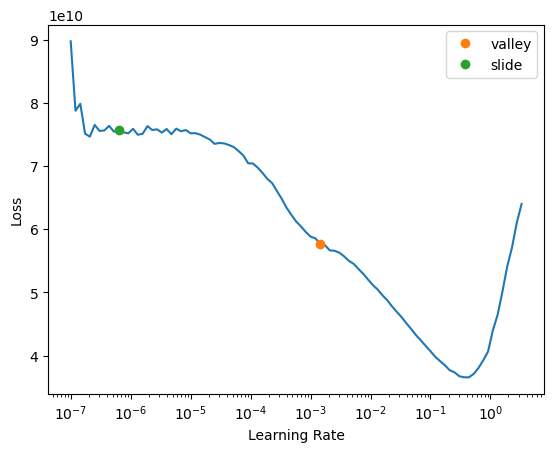

In [45]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [49]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 42317.921875.


(#2) [1857126016.0,42317.921875]

In [50]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 6*25
n2 = 4*25
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()
print('done!')

0 of 100
10 of 100
20 of 100
30 of 100
40 of 100
50 of 100
60 of 100
70 of 100
80 of 100
90 of 100
done!


In [53]:
import http.client, urllib.parse
import json

mrts = ["City Hall MRT", "Bugis MRT", "Lavender MRT", "Kallang MRT", "Aljunied MRT", "Paya Lebar MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 6349
City Hall Station Exit B, Singapore, confidence 1
Bugis Station, Singapore, confidence 1
Lavender Station, Singapore, confidence 1
check Kallang MRT. Flex Kallang Place, Singapore. confidence of 0.8
Aljunied Station, Singapore, confidence 1
Paya Lebar Station, Singapore, confidence 1
pickle dumped. 6350


In [54]:
longLats['Kallang MRT'] = (103.87142, 1.31117)
dump_pkl(longLats)

pickle dumped. 6351


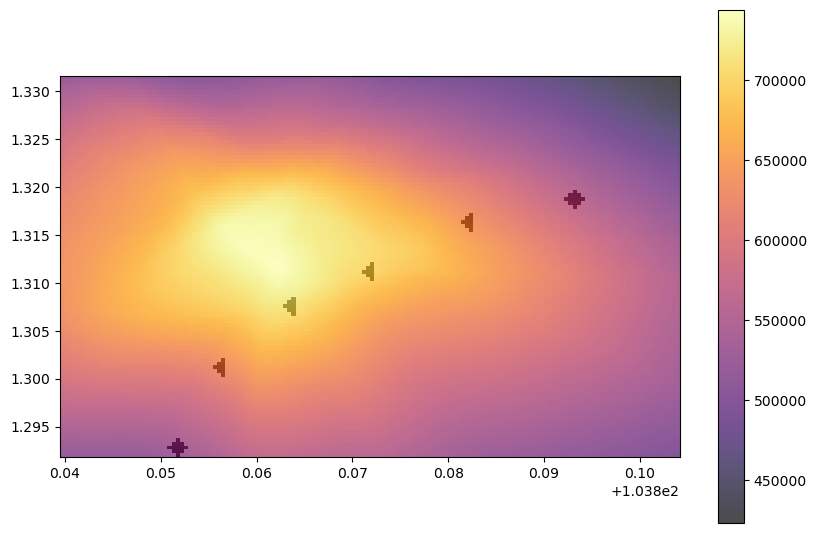

In [55]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_star(*min_coords(*longLats[mrts[0]]))
map_left(*min_coords(*longLats[mrts[1]]))
map_left(*min_coords(*longLats[mrts[2]]))
map_left(*min_coords(*longLats[mrts[3]]))
map_left(*min_coords(*longLats[mrts[4]]))
map_star(*min_coords(*longLats[mrts[5]]))
#map_down(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

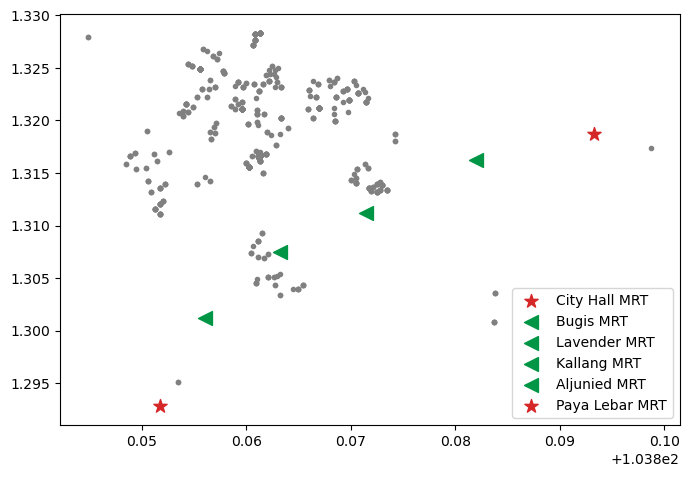

In [57]:
circle = "#FA9E0D"
ew = "#009645"
dt = "#005EC4"
red = '#d62728'
ne = '#9900AA'
markers = ["*", '<', "<", '<', '<', '*', '^']
colors = [red,ew,ew,ew,ew,red]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.',c="gray")
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c=colors[i],label=mrt,s=100)
ax2.legend(loc='lower right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
